<a href="https://colab.research.google.com/github/Velociraptorvelraptor/caption-generation-CNN-RNN-PTL/blob/main/caption_generation_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2023-01-18 14:26:52--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.238.59, 52.216.50.25, 52.216.210.249, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.238.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  99.4MB/s    in 3m 15s  

2023-01-18 14:30:07 (94.8 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2023-01-18 14:30:07--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.194.113, 52.217.226.249, 52.217.78.92, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.194.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

anno

In [2]:
!mkdir coco_data

In [ ]:
!unzip ./train2017.zip -d ./coco_data/

In [4]:
!unzip ./annotations_trainval2017.zip -d ./coco_data/

Archive:  ./annotations_trainval2017.zip
  inflating: ./coco_data/annotations/instances_train2017.json  
  inflating: ./coco_data/annotations/instances_val2017.json  
  inflating: ./coco_data/annotations/captions_train2017.json  
  inflating: ./coco_data/annotations/captions_val2017.json  
  inflating: ./coco_data/annotations/person_keypoints_train2017.json  
  inflating: ./coco_data/annotations/person_keypoints_val2017.json  


In [1]:
!pip install torchvision pytorch-lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 46.2 MB/s eta 0:00:00


In [2]:
### Assembling the data ###
import json
import os
import random
import nltk
import pickle
from PIL import Image
from IPython.display import Image as DisplayImage
from shutil import copyfile
from collections import Counter

### Building and training the model ###
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence as pk_pdd_seq
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.transforms import transforms as T
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger


In [7]:
obj_f = '/content/coco_data/annotations/instances_train2017.json'

with open(obj_f) as f:
  object_detections = json.load(f)

In [8]:
CATEGORY_LIST = [4, 5, 22, 43]
COUNT_PER_CATEGORY = 1000


In [9]:
category_dict = dict()
for category_id in CATEGORY_LIST:
  category_dict[category_id] = dict()

all_images = dict()
filtered_images = set()

for annotation in object_detections['annotations']:
  category_id = annotation['category_id']
  image_id = annotation['image_id']
  area = annotation['area']
  if category_id in CATEGORY_LIST:
    if image_id not in category_dict[category_id]:
      category_dict[category_id][image_id] = []
  if image_id not in all_images:
    all_images[image_id] = dict()
  if category_id not in all_images[image_id]:
    all_images[image_id][category_id] = area
  else:
    current_area = all_images[image_id][category_id]
    if area > current_area:
      all_images[image_id][category_id] = area

In [10]:
if COUNT_PER_CATEGORY == -1:
  for category_id in category_dict:
    print("Processing category {}".format(category_id))
    filtered_images.update(category_dict[category_id].keys())
    print("  Filtered total {} images of category {}".format(len(category_dict[category_id].keys()), category_id))
else:
  for image_id in all_images:
    areas = list(all_images[image_id].values())
    categories = list(all_images[image_id].keys())
    sorted_areas = sorted(areas, reverse=True)
    sorted_categories = []
    for area in sorted_areas:
      sorted_categories.append(categories[areas.index(area)])
    all_images[image_id] = sorted_categories

  for category_id in category_dict:
    print("Processing category {}".format(category_id))
    for image_id in category_dict[category_id]:
      category_dict[category_id][image_id] = all_images[image_id]
    prominance_index = 0
    prominent_image_ids = []
    while len(category_dict[category_id]) > 0 and len(prominent_image_ids) < COUNT_PER_CATEGORY:
      remaining_count = COUNT_PER_CATEGORY - len(prominent_image_ids)
      image_ids = []
      for image_id in category_dict[category_id]:
        if category_dict[category_id][image_id].index(category_id) == prominance_index:
          image_ids.append(image_id)
      for image_id in image_ids:
        del category_dict[category_id][image_id]
      if len(image_ids) <= remaining_count:
        prominent_image_ids = prominent_image_ids + image_ids
        if prominance_index > 4:
          print(image_ids)
        print("  Added all {} images at prominance_index {}".format(len(image_ids), prominance_index))
      else:
        random.shuffle(image_ids)
        prominent_image_ids = prominent_image_ids + image_ids[0:remaining_count]
        print("  Added {} images at prominance_index {} out of {} images".format(remaining_count, prominance_index, len(image_ids)))
      prominance_index = prominance_index + 1
    filtered_images.update(prominent_image_ids)
    print("  Completed filtering of total {} images of category {}".format(len(prominent_image_ids), category_id))

print("Processed all categories. Number of filtered images is {}".format(len(filtered_images)))


Processing category 4
  Added 1000 images at prominance_index 0 out of 2134 images
  Completed filtering of total 1000 images of category 4
Processing category 5
  Added 1000 images at prominance_index 0 out of 2707 images
  Completed filtering of total 1000 images of category 5
Processing category 22
  Added 1000 images at prominance_index 0 out of 1981 images
  Completed filtering of total 1000 images of category 22
Processing category 43
  Added all 30 images at prominance_index 0
  Added 970 images at prominance_index 1 out of 2621 images
  Completed filtering of total 1000 images of category 43
Processed all categories. Number of filtered images is 4000


In [11]:
caps_fl = "/content/coco_data/annotations/captions_train2017.json"
with open(caps_fl) as json_file:
  captions = json.load(json_file)

filtered_annotations = []
for annotation in captions['annotations']:
  if annotation['image_id'] in filtered_images:
    filtered_annotations.append(annotation)
captions['annotations'] = filtered_annotations
print("Number of filtered annotations is {}".format(len(captions['annotations'])))

images = []
filtered_image_file_names = set()
for image in captions['images']:
  if image['id'] in filtered_images:
    images.append(image)
    filtered_image_file_names.add(image['file_name'])
captions['images'] = images
print("Expected number of filtered images is {}, actual number is {}".format(len(filtered_images), len(captions['images'])))


Number of filtered annotations is 20012
Expected number of filtered images is 4000, actual number is 4000


In [12]:
with open("./coco_data/captions.json", 'w+') as output_file:
  json.dump(captions, output_file)

In [13]:
!mkdir coco_data/images
for file_name in filtered_image_file_names:
  copyfile("./coco_data/train2017/{}".format(file_name),
           "./coco_data/images/{}".format(file_name))


In [14]:
def resize_img(input_path, output_path, new_size):
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  img_files = os.listdir(input_path)
  n_img = len(img_files)
  for i, img in enumerate(img_files):
    img_full_path = os.path.join(input_path, img)
    with open(img_full_path, 'r+b') as f:
      with Image.open(f) as image:
        image = image.resize(new_size, Image.ANTIALIAS)
        img_sv_full_path = os.path.join(output_path, img)
        image.save(img_sv_full_path, image.format)
    if (i+1) % 1000 == 0 or (i+1) == n_img:
      print(f'Resized and saved {i+1} images out of {n_img}')

In [15]:
in_path = '/content/coco_data/images'
out_path = '/content/coco_data/resized_images'

resize_img(in_path, out_path, [256, 256])

Resized and saved 1000 images out of 4000
Resized and saved 2000 images out of 4000
Resized and saved 3000 images out of 4000
Resized and saved 4000 images out of 4000


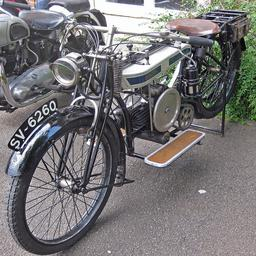

In [24]:
DisplayImage(filename='/content/coco_data/resized_images/000000000073.jpg') 

In [3]:
class Vocabulary(object):
    def __init__(self):
        self.token_to_int = {}
        self.int_to_token = {}
        self.current_index = 0

    def __call__(self, token):
        if not token in self.token_to_int:
            return self.token_to_int['<unk>']
        return self.token_to_int[token]

    def __len__(self):
        return len(self.token_to_int)

    def add_token(self, token):
        if not token in self.token_to_int:
            self.token_to_int[token] = self.current_index
            self.int_to_token[self.current_index] = token
            self.current_index += 1

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
def build_vocab(json_path, threshold):
  with open(json_path) as json_file:
    captions = json.load(json_file)
  n_captions = len(captions['annotations'])
  counter = Counter()
  i = 0 
  for annotation in captions['annotations']:
    i += 1
    caption = annotation['caption']
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    counter.update(tokens)
    if i % 1000 or i == n_captions:
      print(f'Tokenized {i} out of total '
            f'{n_captions} captions.')
      
  tokens = [tkn for tkn, i in counter.items() if i >= threshold]

  vocabulary = Vocabulary()
  vocabulary.add_token('<pad>')
  vocabulary.add_token('<start>')
  vocabulary.add_token('<end>')
  vocabulary.add_token('<unk>')

  for i, token in enumerate(tokens):
    vocabulary.add_token(token)
  return vocabulary

In [ ]:
vocabulary = build_vocab(json_path='/content/coco_data/captions.json', threshold=4)
vocabulary_path = '/content/coco_data/vocabulary.pkl'
with open(vocabulary_path, 'wb') as f:
    pickle.dump(vocabulary, f)
print("Total vocabulary size: {}".format(len(vocabulary)))

In [7]:
src_path = '/content/drive/MyDrive/Colab Notebooks/CNN-RNN-COCO/coco_data'

In [8]:
#!mv '/content/coco_data/vocabulary.pkl' '/content/drive/MyDrive/Colab Notebooks/CNN-RNN-COCO/coco_data'

In [9]:
class CocoDataset(Dataset):
  def __init__(self, data_path, json_path, vocab, transform=None):
    self.img_dir = data_path
    self.vocab = vocab
    self.transform = transform
    with open(json_path) as f:
      self.coco = json.load(f)
    self.image_id_file_name = dict()
    for image in self.coco['images']:
      self.image_id_file_name[image['id']] = image['file_name']

  def __getitem__(self, idx):
    annotation = self.coco['annotations'][idx]
    caption = annotation['caption']
    tkns = nltk.tokenize.word_tokenize(str(caption).lower())
    caption = []
    caption.append(self.vocab('<start>'))
    caption.extend([self.vocab(tkn) for tkn in tkns])
    caption.append(self.vocab('<end>'))

    img_id = annotation['image_id']
    image_f = self.image_id_file_name[img_id]
    img_path = os.path.join(self.img_dir, image_f)
    img = Image.open(img_path).convert('RGB')
    if self.transform is not None:
      img = self.transform(img)

    return img, torch.Tensor(caption)

  def __len__(self):
    """
    There is 5 captions per image, so total length of the 
    dataset is equal to the total n of captions.
    """
    return len(self.coco['annotations']) 

In [10]:
def coco_collate_fn(data_batch):
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)

    imgs = torch.stack(imgs, 0)

    cap_lens = [len(cap) for cap in caps]
    padded_caps = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        padded_caps[i, :end] = cap[:end]
    return imgs, padded_caps, cap_lens

In [11]:
def get_loader(data_path, json_path, vocab, transform, batch_size, shuffle, num_workers=0):
  coco_ds = CocoDataset(data_path, json_path, vocab, transform)
  coco_dl = DataLoader(coco_ds, batch_size, shuffle, num_workers=num_workers, collate_fn = coco_collate_fn)
  return coco_dl

In [12]:
class HybridModel(pl.LightningModule):
  def __init__(self, cnn_embdng_sz, lstm_embdng_sz, lstm_hidden_lyr_sz, 
               lstm_vocab_sz, lstm_num_lyrs, max_seq_len=20):
    super(HybridModel, self).__init__()

    resnet = models.resnet152(pretrained=False)
    module_list = list(resnet.children())[:-1]
    self.cnn_resnet = nn.Sequential(*module_list)
    self.cnn_linear = nn.Linear(resnet.fc.in_features, cnn_embdng_sz)
    self.cnn_batch_norm = nn.BatchNorm1d(cnn_embdng_sz, momentum=0.01)
    
    self.lstm_embdng_lyr = nn.Embedding(lstm_vocab_sz, lstm_embdng_sz)
    self.lstm_lyr = nn.LSTM(lstm_embdng_sz, lstm_hidden_lyr_sz, lstm_num_lyrs, batch_first=True)
    self.lstm_linear = nn.Linear(lstm_hidden_lyr_sz, lstm_vocab_sz)
    self.max_seq_len = max_seq_len
    self.save_hyperparameters()
    print('Hparameters saved')

  def forward(self, input, caps, lens):
    features = self.cnn_resnet(input)
    features = features.reshape(features.size(0), -1)
    features = self.cnn_linear(features)
    cnn_features = self.cnn_batch_norm(features)
    embeddings = self.lstm_embdng_lyr(caps)
    embeddings = torch.cat((cnn_features.unsqueeze(1), embeddings), 1)
    lstm_input = pk_pdd_seq(embeddings, lens, batch_first=True)
    hddn_vars, _ = self.lstm_lyr(lstm_input)
    model_outputs = self.lstm_linear(hddn_vars[0])
    return model_outputs

  def configure_optimizers(self):
    params = list(self.lstm_embdng_lyr.parameters()) + \
             list(self.lstm_lyr.parameters()) + \
             list(self.lstm_linear.parameters()) + \
             list(self.cnn_linear.parameters()) + \
             list(self.cnn_batch_norm.parameters())
    optimizer = torch.optim.Adam(params, lr=0.0003)
    return optimizer

  def training_step(self, batch, batch_idx):
    loss_criterion = nn.CrossEntropyLoss()
    imgs, caps, lens = batch
    outputs = self(imgs, caps, lens)
    targets = pk_pdd_seq(caps, lens, batch_first=True)[0]
    loss = loss_criterion(outputs, targets)
    self.log('train_loss', loss, on_epoch=True)
    return loss

In [26]:
transform = T.Compose([
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [14]:
with open(src_path + '/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

In [27]:
coco_data_loader = get_loader(src_path+'/resized_images',
                              src_path+'/captions.json',
                              vocabulary,
                              transform, 
                              batch_size=128,
                              shuffle=True,
                              num_workers=4)

In [28]:
model = HybridModel(256, 256, 512, len(vocabulary), 1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Hparameters saved


In [29]:
trainer = pl.Trainer(gpus=-1, precision=16, max_epochs=100, limit_train_batches=0.2, logger=CSVLogger(save_dir='logs/', name='exp_00001'))

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model, coco_data_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type        | Params
------------------------------------------------
0 | cnn_resnet      | Sequential  | 58.1 M
1 | cnn_linear      | Linear      | 524 K 
2 | cnn_batch_norm  | BatchNorm1d | 512   
3 | lstm_embdng_lyr | Embedding   | 432 K 
4 | lstm_lyr        | LSTM        | 1.6 M 
5 | lstm_linear     | Linear      | 866 K 
------------------------------------------------
61.5 M    Trainable params
0         Non-trainable params
61.5 M    Total params
123.089   Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [32]:
import pandas as pd
import seaborn as sns

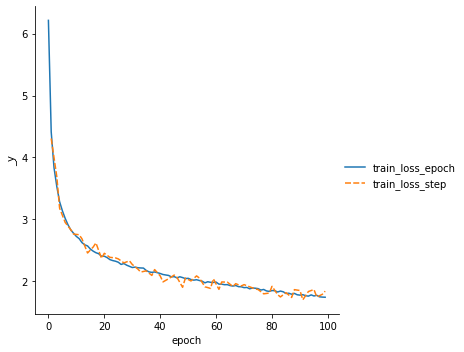

In [33]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sns.relplot(data=metrics, kind="line")
     

In [34]:
!mv '/content/logs/exp_00001/version_3' '/content/drive/MyDrive/Colab Notebooks/CNN-RNN-COCO/coco_data/exp__0001'